In [1635]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.reload_library()
from  matplotlib.ticker import FuncFormatter
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils

In [ ]:
unique_valuesunique_values

In [3]:
%cd ../..

/home/belu/VS Workplace/licentiate-thesis-repo


In [1422]:
df = utils.read_data(raw_data_path, organic_key=True, solvent=None)

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [1423]:
df.shape

(8056, 72)

## Amines Pre-processing

### Filter unknown features

In [1484]:
unknown_cols = ["_feat_ProtPolarSurfaceArea", "_feat_Protpsa",
                "_feat_molsurfaceareaASAp", "_feat_molsurfaceareaVDWp",
                "_feat_msareaASAp", "_feat_msareaVDWp"]

In [1485]:
feats = utils.chem_feats()

In [1486]:
selected_FQ = [feat for feat in [ORGANOAMONIUM_INCHI_KEY_COL]+feats if feat not in unknown_cols]

In [1487]:
amines_feats = df[selected_FQ].drop_duplicates()

In [1488]:
amines_feats = amines_feats.drop(ORGANOAMONIUM_INCHI_KEY_COL, axis=1)

Clean up features names

In [1505]:
feats = list(amines_feats.columns)

amines_names = [name[6:] for name in feats]

amines_names = [name.replace("_", " ") for name in amines_names]

amines_names = [name[:name.find(" ")] + name[name.find(" ")+1].upper() + name[name.find(" ")+2:]
               if (" " in name) else name for name in amines_names]

amines_names = [name.strip(' ') for name in amines_names]

In [1506]:
amines_feats.shape

(43, 61)

### Summary Amines Table

In [1527]:
summary = round(amines_feats.describe().T.drop("count", axis=1), 2)

In [1528]:
summary = summary.reset_index().rename(columns={"index": "Feature"})

In [1529]:
summary["Nombre"] = amines_names

In [1530]:
summary = summary.sort_values(by="Feature")

In [1531]:
summary

,Feature,mean,std,min,25%,50%,75%,max,Nombre
28,_feat_ASA,268.14,62.39,163.99,229.50,256.81,302.12,524.51,ASA
40,_feat_ASA+,206.88,48.48,120.89,177.76,197.61,229.80,398.73,ASA+
23,_feat_ASA-,61.25,30.19,0.00,42.88,64.46,72.49,149.19,ASA-
39,_feat_ASA_H,206.03,76.24,33.15,173.37,201.33,232.38,481.73,ASAH
56,_feat_ASA_P,62.10,34.58,13.65,41.63,50.92,79.62,155.76,ASAP
...,...,...,...,...,...,...,...,...,...
50,_feat_fr_piperzine,0.00,0.00,0.00,0.00,0.00,0.00,0.00,frPiperzine
60,_feat_fr_pyridine,0.02,0.15,0.00,0.00,0.00,0.00,1.00,frPyridine
7,_feat_fr_quatN,1.12,0.50,0.00,1.00,1.00,1.00,2.00,frQuatN
52,_feat_maximalprojectionsize,5.25,0.79,3.40,5.06,5.27,5.70,7.19,maximalprojectionsize


In [1532]:
df_amines_names = pd.read_csv("data/metadata/describe_feat_fq_description.csv")

In [1533]:
df_amines_names = df_amines_names.sort_values(by="Feature")

In [1534]:
summary

,Feature,mean,std,min,25%,50%,75%,max,Nombre
28,_feat_ASA,268.14,62.39,163.99,229.50,256.81,302.12,524.51,ASA
40,_feat_ASA+,206.88,48.48,120.89,177.76,197.61,229.80,398.73,ASA+
23,_feat_ASA-,61.25,30.19,0.00,42.88,64.46,72.49,149.19,ASA-
39,_feat_ASA_H,206.03,76.24,33.15,173.37,201.33,232.38,481.73,ASAH
56,_feat_ASA_P,62.10,34.58,13.65,41.63,50.92,79.62,155.76,ASAP
...,...,...,...,...,...,...,...,...,...
50,_feat_fr_piperzine,0.00,0.00,0.00,0.00,0.00,0.00,0.00,frPiperzine
60,_feat_fr_pyridine,0.02,0.15,0.00,0.00,0.00,0.00,1.00,frPyridine
7,_feat_fr_quatN,1.12,0.50,0.00,1.00,1.00,1.00,2.00,frQuatN
52,_feat_maximalprojectionsize,5.25,0.79,3.40,5.06,5.27,5.70,7.19,maximalprojectionsize


In [1535]:
summary["Descripción"] = df_amines_names["Descripción"]

In [1536]:
cols = summary.columns.to_list()
cols = ["Nombre", "Descripción"] + cols[2:-2] + ["Feature"]

In [1538]:
df_final_feat = summary[cols]

In [1541]:
df_final_feat.to_csv("data/metadata/FQ_features_summary_table.csv", index=None)

In [1545]:
feat_list = list(df_final_feat["Feature"])

In [1551]:
names_fq_list = list(df_final_feat["Nombre"])

### FQ chem features

In [1575]:
df_amines_names = "data/FQ_amines_name.csv"
df_amines_features = "data/FQ_amines_feature.csv"

In [1715]:
df_amines_features = amines_feats[feat_list]

In [1571]:
df_amines_features.to_csv(df_amines_features, index=None)

In [1717]:
df_amines_features.columns = names_fq_list

In [1573]:
df_amines_features.to_csv(df_amines_names, index=None)

In [1728]:
df_amines_features.to_csv("data/feat_amines_names.csv", index=None)

## EDA: amines FQ descriptors

In [1994]:
df = pd.read_csv(df_amines_names)

Filter constant amines

In [1995]:
df = df.loc[:, (df != df.iloc[0]).any()]

In [1996]:
df.shape

(43, 57)

In [2012]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values = unique_values.to_frame("count").reset_index().rename(columns = {'index':'propiedad'})

plot_title = "figures/propiedades_valores_unicos.pdf"

In [2013]:
unique_values['type_var'] = pd.cut(unique_values['count'],
                              bins=[0, 2, 14, 50],
                              labels=["binaria", "ordinal", "continua"])

In [2014]:
unique_values['range_unique_values'] = pd.cut(unique_values['count'],
                              bins=[1, 2, 14, 50])

In [2015]:
unique_values.shape

(57, 4)

In [2016]:
outlier_value_index = unique_values[unique_values.propiedad == "PolarSurfaceArea"].index[0]
unique_values.at[outlier_value_index, "type_var"] = "continua"

In [2017]:
unique_values[unique_values.propiedad == "PolarSurfaceArea"]

,propiedad,count,type_var,range_unique_values
32,PolarSurfaceArea,11,continua,"(2, 14]"


In [2021]:
unique_values

,propiedad,count,type_var,range_unique_values
0,frAmidine,2,binaria,"(1, 2]"
1,frNH1,2,binaria,"(1, 2]"
2,HeteroaromaticRingCount,2,binaria,"(1, 2]"
3,HeteroaliphaticRingCount,2,binaria,"(1, 2]"
4,CyclomaticNumber,2,binaria,"(1, 2]"
5,CarboaromaticRingCount,2,binaria,"(1, 2]"
6,CarboaliphaticRingCount,2,binaria,"(1, 2]"
7,CarboRingCount,2,binaria,"(1, 2]"
8,frImine,2,binaria,"(1, 2]"
9,frGuanido,2,binaria,"(1, 2]"


In [2022]:
df_type_var = unique_values.groupby("type_var").aggregate({"type_var":'first',
                                                           "range_unique_values": 'last',
                                                           "propiedad": 'count'})

In [2024]:
df_type_var

,type_var,range_unique_values,propiedad
type_var,,,
binaria,binaria,"(1, 2]",17
ordinal,ordinal,"(2, 14]",18
continua,continua,"(14, 50]",22


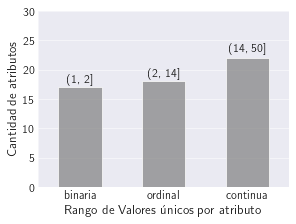

In [2025]:
plot_title = "figures/propiedades_valores_unicos.pdf"

        
with plt.style.context(['science', 'bright']):
    #sns.set_palette(sns.color_palette(color_bright))
    fig, axes = plt.subplots(1, 1, figsize=(4,3),
                                 constrained_layout = True)
    ax = sns.barplot(x=df_type_var.index, y="propiedad", orient="v", data=df_type_var,
                     color="grey", alpha=0.7)
    #ax.set_title("Distribución Calidad de Cristal")

    # Remove box lines
    sns.despine(bottom = True, left = False, trim=False)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    #ax.xticks(fontdict={'fontsize':15})
    #ax.tick_params(axis='both', which='both')
    ax.set_ylabel("Cantidad de Propiedades FQs", fontdict={'fontsize':13})
    ax.set_xlabel("Tipo de Variable", fontdict={'fontsize':13})
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    #plt.xticks()
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    

    for n, p in enumerate(ax.patches):
        text = str(df_type_var.iloc[n,1])
        width = p.get_width()
        new_width = width * 0.65
        p.set_width(new_width)
        x = p.get_x()
        p.set_x(x + (width - new_width) / 2)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() * 1.075
        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12)

    #plt.legend(title="Tipo de Variable", fontsize=13)
    plt.ylim(0,30)

In [1910]:
unique_values.to_csv("data/metadata/type_var_fq_bins.csv", index=None)

In [1911]:
unique_values

,propiedad,count,type_var,range_unique_values
0,frAmidine,2,binaria,"(1, 2]"
1,frNH1,2,binaria,"(1, 2]"
2,HeteroaromaticRingCount,2,binaria,"(1, 2]"
3,HeteroaliphaticRingCount,2,binaria,"(1, 2]"
4,CyclomaticNumber,2,binaria,"(1, 2]"
5,CarboaromaticRingCount,2,binaria,"(1, 2]"
6,CarboaliphaticRingCount,2,binaria,"(1, 2]"
7,CarboRingCount,2,binaria,"(1, 2]"
8,frImine,2,binaria,"(1, 2]"
9,frGuanido,2,binaria,"(1, 2]"


In [1912]:
def plot_type_vars(df): 
    unique_values = df.select_dtypes(include="number").nunique().sort_values()

    unique_values = unique_values.to_frame("count").reset_index().rename(columns = {'index':'propiedad'})

    unique_values['type_var'] = pd.cut(unique_values['count'],
                              bins=[0, 2, 11, 15, 50],
                              labels=["binario", "ordinal","precontinua", "continua"])
    
    plot_title = "figures/propiedades_valores_unicos.pdf"
    with plt.style.context(['science', 'bright']):
        #sns.set_palette(sns.color_palette(color_bright))
        fig, axes = plt.subplots(1, 1, figsize=(6,15),
                                     constrained_layout = True)
        ax = sns.barplot(x="count", y="propiedad", orient="h", data=unique_values,
                        hue="type_var")
        #ax.set_title("Distribución Calidad de Cristal")

        # Remove box lines
        sns.despine(bottom = True, left = True, trim=False)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #ax.xticks(fontdict={'fontsize':15})
        #ax.tick_params(axis='both', which='both')
        ax.set_xlabel("Valores únicos por atributo", fontdict={'fontsize':13})
        ax.set_ylabel("Descriptores físico-químicos", fontdict={'fontsize':13})
        #plt.xticks()
        plt.xticks(fontsize=10, rotation=0)
        plt.yticks(fontsize=10, rotation=0)
        plt.legend(title="Tipo de Variable", fontsize=13)
        #ax.set(adjustable='box')
        #fig.savefig(plot_title, dpi=300)
    

### Variables Continuas

In [1937]:
df_cont_col = pd.read_csv("data/metadata/type_var_fq_bins.csv")
cont_cols = df_cont_col[df_cont_col.type_var != "binaria"]["propiedad"]

In [1938]:
len(cont_cols)

40

In [1941]:
df_cont_col = df_cont_col.rename(columns={"type_var": "Tipo de Variable"})

In [1943]:
labels = df_cont_col[df_cont_col["Tipo de Variable"] != "binaria"]["Tipo de Variable"]

In [1944]:
import seaborn as sns
sns.set_theme()

# Load the brain networks example dataset
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)


In [1945]:
bright = plot_utils.tol_cset("vibrant")
bright_reorderd = [bright.magenta, bright.teal]

In [1946]:
bright

Vcset(orange='#EE7733', blue='#0077BB', cyan='#33BBEE', magenta='#EE3377', red='#CC3311', teal='#009988', grey='#BBBBBB', black='#000000')

In [1947]:
lut = dict(zip(labels.unique(), bright_reorderd))
label_color = labels.map(lut)

In [1951]:
df = pd.read_csv("data/feat_amines_names.csv")[cont_cols]

In [1952]:
label_color.index = df.corr().index

In [1965]:
ax.add_legend?

Signature:
ax.add_legend(
    legend_data=None,
    title=None,
    label_order=None,
    adjust_subtitles=False,
    **kwargs,
)
Docstring:
Draw a legend, maybe placing it outside axes and resizing the figure.

Parameters
----------
legend_data : dict
    Dictionary mapping label names (or two-element tuples where the
    second element is a label name) to matplotlib artist handles. The
    default reads from ``self._legend_data``.
title : string
    Title for the legend. The default reads from ``self._hue_var``.
label_order : list of labels
    The order that the legend entries should appear in. The default
    reads from ``self.hue_names``.
adjust_subtitles : bool
    If True, modify entries with invisible artists to left-align
    the labels and set the font size to that of a title.
kwargs : key, value pairings
    Other keyword arguments are passed to the underlying legend methods
    on the Figure or Axes object.

Returns
-------
self : Grid instance
    Returns self for easy cha

Text(0.5, 1.0, 'my cbar label')

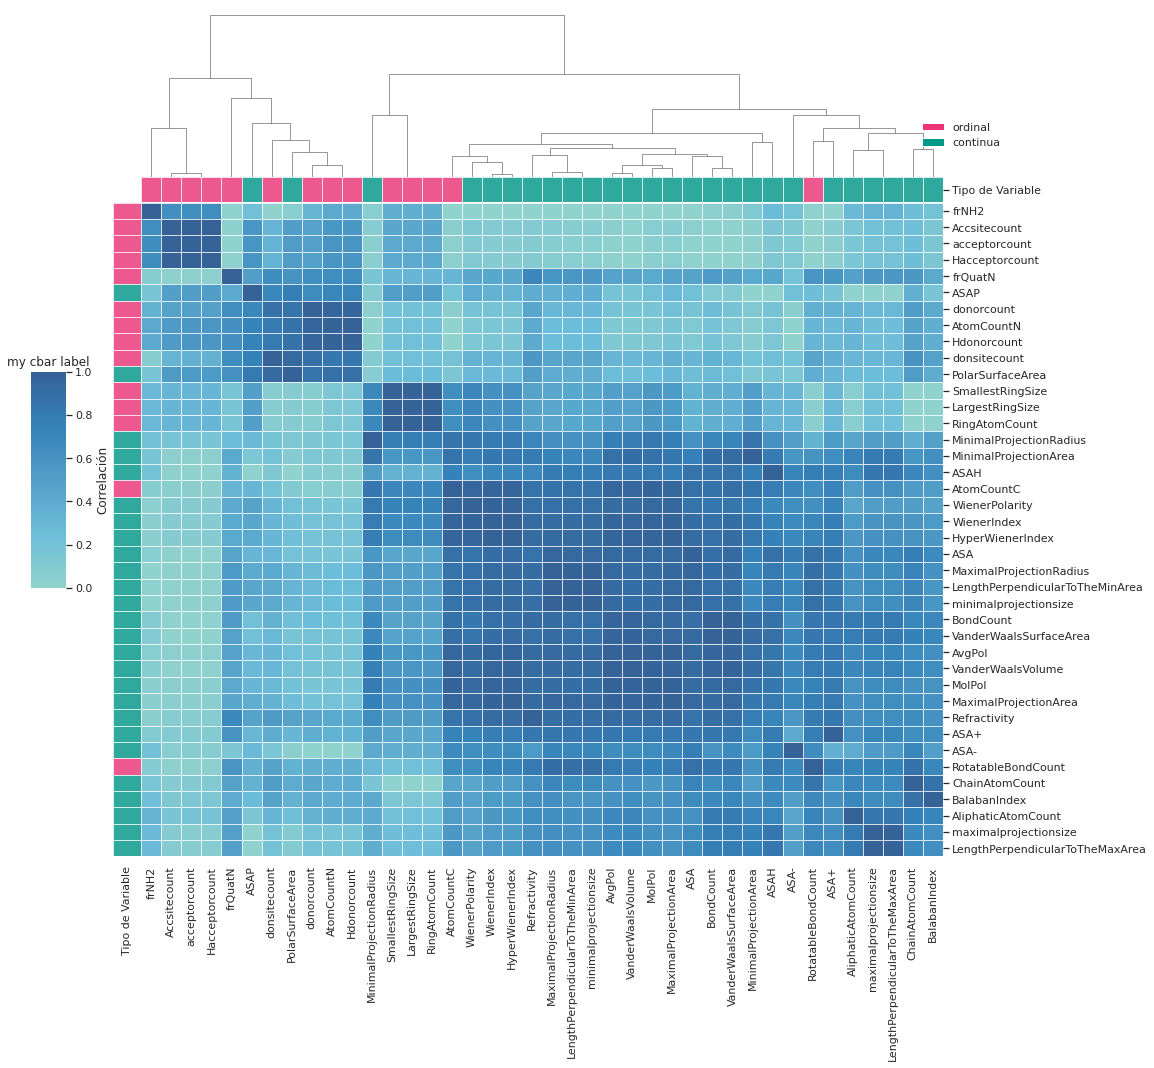

In [1975]:
from matplotlib.patches import Patch

plot_title=

fig, ax = plt.subplots(1, 1, figsize=(6,15), constrained_layout = True)

ax = sns.clustermap(df.corr(method="spearman"), row_cluster=True, standard_scale=1, 
                    center=0, col_colors=label_color, cmap="GnBu", row_colors=label_color, alpha=0.8,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .45, .03, .2),
                   linewidths=.75, figsize=(16, 15))
                    #cbar_kws={'label':"Correlación"})

handles = [Patch(facecolor=lut[name]) for name in lut]
                                            
plt.legend(handles, lut, title='',
           bbox_to_anchor=(0.87, 0.89), bbox_transform=plt.gcf().transFigure,
           facecolor='white', framealpha=1, frameon=False)

ax.ax_row_dendrogram.remove()

ax.cax.set_title("Correlación")

fig.savefig(plot_title, dpi=300)


In [1735]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_pca(df, cols, n_components):
    scaler = StandardScaler()
    std_df =pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
    pca_number = min(len(cols), n_components)
    pca_columns = ['PCA_'+ str(n) for n in range(1,pca_number+1)]
    pca = PCA(n_components=pca_number, svd_solver = 'auto')
    principal_components=pca.fit_transform(std_df)
    pca_df = pd.DataFrame(data = principal_components, columns = pca_columns)
    return pca, pca_df

In [1736]:
pca, pca_df = apply_pca(df, df.columns, 2)

In [1737]:
def plot_main_pca(df):
    df['group'] = ["Grupo 2" if x >= 0 else "Grupo 1" for x in df['PCA_2']]
    #df['group'] = np.where(df['PCA_1']>=12, 2)

    df.at[24, "group"] = "Outlier"

    bright = plot_utils.tol_cset("vibrant")
    bright_reorderd = [bright.magenta, bright.teal, bright.grey]

    colors = {"Grupo 1": bright.magenta, 
             "Grupo 2": bright.teal}

    from scipy import interpolate
    from scipy.spatial import ConvexHull
    #sns.set_palette(sns.color_palette("Paired"))
    #sns.set_context("paper")
    plot_title = "figures/organoaminas_pca_visual"
    with plt.style.context(['science', 'light']):
        #sns.set_palette(sns.color_palette(color_bright))

        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(6,4),
                                 constrained_layout = True)

        #fig.suptitle('Distribución de Reactivos')

        sns.scatterplot(x="PCA_1", y="PCA_2", hue="group",
                        palette=bright_reorderd,
                    sizes=(1, 8), linewidth=0,
                    data=df, ax=axes)
        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        axes.set_xlabel("1er Componente Principal",  fontdict={"size": 13})
        axes.set_ylabel("2da Componente Principal", fontdict={"size": 13})

        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        plt.legend(title="", loc=(0.8,0.8), fontsize=11)


        plt.vlines(x=0, ymin=-6, ymax=8,  ls='--', colors="black", alpha=0.7)
        plt.hlines(y=0, xmin=-13, xmax=18, ls='--', colors="black", alpha=0.7)
        #axes.axvline(12, ymin=0, ymax=2)

        #fig.supxlabel('Concentración (M)', fontdict={"size":12})
        #sns.color_palette()
        #fig.supylabel('Cantidad')
        #fig.savefig(plot_title+'.pdf', dpi=300)
        #fig.show()
        #plt.subplot_tool()

        for i in df.group.unique()[:2]:
            # get the convex hull
            points = df[df.group == i][['PCA_1', 'PCA_2']].values
            hull = ConvexHull(points)
            x_hull = np.append(points[hull.vertices,0],
                               points[hull.vertices,0][0])
            y_hull = np.append(points[hull.vertices,1],
                               points[hull.vertices,1][0])

            # interpolate
            dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
            dist_along = np.concatenate(([0], dist.cumsum()))
            spline, u = interpolate.splprep([x_hull, y_hull], 
                                            u=dist_along, s=0)
            interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
            interp_x, interp_y = interpolate.splev(interp_d, spline)
            # plot shape
            plt.fill(interp_x, interp_y, '--', alpha=0.3, c=colors[i])
        #fig.savefig(plot_title+'.pdf', dpi=300)


In [1742]:
def plot_amines_pca(df):
    #df['group'] = ["Grupo 2" if x >= 0 else "Grupo 1" for x in df['PCA_2']]
    #df['group'] = np.where(df['PCA_1']>=12, 2)

    #df.at[24, "group"] = "Outlier"

    bright = plot_utils.tol_cset("vibrant")
    bright_reorderd = [bright.magenta, bright.teal, bright.grey]

    colors = {"Grupo 1": bright.magenta, 
             "Grupo 2": bright.teal}

    from scipy import interpolate
    from scipy.spatial import ConvexHull
    #sns.set_palette(sns.color_palette("Paired"))
    #sns.set_context("paper")
    plot_title = "figures/organoaminas_pca_visual"
    with plt.style.context(['science', 'light']):
        #sns.set_palette(sns.color_palette(color_bright))

        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(6,4),
                                 constrained_layout = True)

        #fig.suptitle('Distribución de Reactivos')

        sns.scatterplot(x="PCA_1", y="PCA_2",
                        palette=bright_reorderd,
                    sizes=(1, 8), linewidth=0,
                    data=df, ax=axes)
        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        axes.set_xlabel("1er Componente Principal",  fontdict={"size": 13})
        axes.set_ylabel("2da Componente Principal", fontdict={"size": 13})

        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        plt.legend(title="", loc=(0.8,0.8), fontsize=11)


        plt.vlines(x=0, ymin=-6, ymax=8,  ls='--', colors="black", alpha=0.7)
        plt.hlines(y=0, xmin=-13, xmax=18, ls='--', colors="black", alpha=0.7)
        #axes.axvline(12, ymin=0, ymax=2)

        #fig.supxlabel('Concentración (M)', fontdict={"size":12})
        #sns.color_palette()
        #fig.supylabel('Cantidad')
        #fig.savefig(plot_title+'.pdf', dpi=300)
        #fig.show()
        #plt.subplot_tool()
        #fig.savefig(plot_title+'.pdf', dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


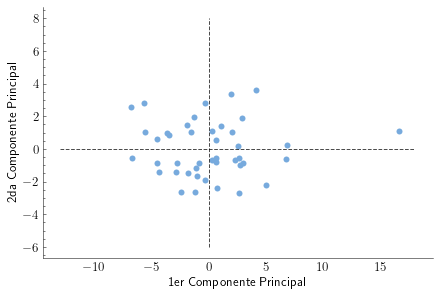

In [1743]:
plot_amines_pca(pca_df)

In [1739]:
pca.components_.shape

(2, 26)

In [1744]:
from math import atan2, degrees
import math

def anti_clockwise(x,y):
    alpha = degrees(atan2(y,x))
    return (alpha + 360) % 360

def biplot(score, coeff, texts, cutoff=0):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    
    xs = pd.DataFrame(np.transpose(pca.components_[0:2, :]))
    xs["name"] = texts

    xs["angle"] = xs.apply(lambda x: anti_clockwise(x[0], x[1]), axis=1)
    xs["norm"] = xs.apply(lambda x: LA.norm([x[0], x[1]]), axis=1)
    range_ls = list(range(0,420,60))
    xs["cuadrante"] = pd.cut(xs["angle"], range_ls, precision=0, labels=np.arange(1,len(range_ls)))
    norm_best = xs.groupby(["cuadrante"])["norm"].transform(max) == xs['norm']
    dots_to_plot = xs[norm_best].groupby("cuadrante").first()
    
    dots_to_plot["name"] = ["Cantidad de átomos de C",
                            "Tamaño del anillo más chico",
                            "Multiplicidad de aceptores de enlace de H",
                            "Área polar superficial",
                           #"Número de aminas aromáticas", 
                           "Cantidad de átomos H donores", 
                           "Cantidad de átomos en anillo aromático"]
    
    #print(norm_best)
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(6,4), dpi=100)
    markers=['o','^','x']
    #plt.scatter(xs*scalex,ys*scaley, s=8) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        #if xs["norm"] > cutoff:
        #    plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 0.3)
        #    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, texts[i], color = 'k', ha = 'center', va = 'center',fontsize=6)
        #else:
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'grey', alpha = 0.5,linestyle = '--',linewidth = 0.3)
    
    print(dots_to_plot)
    for row in dots_to_plot.iterrows():
        if row[1][0] < 0:
            plt.text(row[1][0]*1.9*(len(texts[a])*0.06), row[1][1]*1.05, s=row[1]["name"], color = 'k', ha = 'center', va = 'center',fontsize=6)
        else:
            plt.text(row[1][0], row[1][1]*1.05, s=row[1]["name"], color = 'k', ha = 'center', va = 'center',fontsize=6)
            
        
    plt.xlabel("PC{}".format(1), size=11)
    plt.ylabel("PC{}".format(2), size=11)
    limx= 0.3
    limy= 0.4
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=12)


In [1745]:
#cols = df.columns

xs = pd.DataFrame(np.transpose(pca.components_[0:2, :]))
xs["name"] = cols
xs["angle"] = xs.apply(lambda x: anti_clockwise(x[0], x[1]), axis=1)
xs["norm"] = xs.apply(lambda x: LA.norm([x[0], x[1]]), axis=1)
xs["cuadrante"] = pd.cut(xs["angle"],list(range(0,420,60)), precision=0, labels=np.arange(1,7))
norm_best = xs.groupby(["cuadrante"])["norm"].transform(max) == xs['norm']
dots_to_plot = xs[norm_best].groupby("cuadrante").first()

dots_to_plot["name"] = ["Cantidad de átomos de C",
                        "Tamaño del anillo más chico",
                        "Multiplicidad de aceptores de enlace de H",
                        "Área polar superficial",
                       #"Número de aminas aromáticas", 
                       "Cantidad de átomos H donores", 
                       "Cantidad de átomos en anillo aromático"]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                  0         1                                       name  \
cuadrante                                                                  
1          0.168006  0.290368                    Cantidad de átomos de C   
2         -0.046074  0.527260                Tamaño del anillo más chico   
3               NaN       NaN  Multiplicidad de aceptores de enlace de H   
4               NaN       NaN                     Área polar superficial   
5          0.162458 -0.345713               Cantidad de átomos H donores   
6          0.210185 -0.210403     Cantidad de átomos en anillo aromático   

                angle      norm  
cuadrante                        
1           59.946509  0.335470  
2           94.994036  0.529269  
3                 NaN       NaN  
4                 NaN       NaN  
5          295.169910  0.381982  
6          314.970279  0.297400  


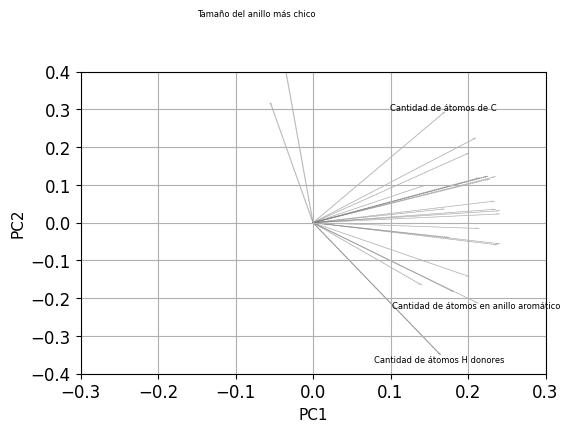

In [1746]:
biplot(pca_df.values, np.transpose(pca.components_[0:2, :]), df.columns, 0.40)

In [1764]:
n_components = 5
pca, pca_df = apply_pca(df, df.columns, n_components)

In [1765]:
pca.components_.shape

(5, 26)

In [1766]:
pca.components_[:, :].T.shape

(26, 5)

In [1767]:
loadings = pd.DataFrame(pca.components_[:, :].T, columns=["PC %s" % s for s in range(1,n_components+1)], index=df.columns)

In [1768]:
loadings.columns

Index(['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'], dtype='object')

In [1769]:
df.head()

,ChainAtomCount,PolarSurfaceArea,AliphaticAtomCount,WienerPolarity,BondCount,BalabanIndex,WienerIndex,HyperWienerIndex,MolPol,MinimalProjectionRadius,...,MinimalProjectionArea,ASAP,Refractivity,ASA,VanderWaalsSurfaceArea,ASAH,ASA-,ASA+,VanderWaalsVolume,MaximalProjectionArea
0,6,32.08,6,3,19,2.63,32,58,11.03,3.13,...,22.95,56.48,50.25,275.35,202.37,218.87,46.05,229.29,109.27,39.14
1,0,14.14,0,3,12,2.00,27,42,9.68,3.39,...,19.09,54.82,25.16,239.88,132.81,185.06,17.39,222.49,80.02,33.64
2,5,27.64,5,2,16,2.19,20,35,9.57,2.69,...,18.77,48.89,35.09,273.98,173.44,225.09,70.99,202.99,93.45,34.38
3,6,27.64,6,3,19,3.17,28,44,11.42,3.38,...,27.08,36.88,39.35,254.69,207.49,217.80,59.57,195.11,110.90,34.29
4,0,16.61,5,0,15,1.67,15,20,8.83,3.23,...,22.96,25.71,33.65,219.25,149.68,193.54,32.61,186.64,82.42,28.06


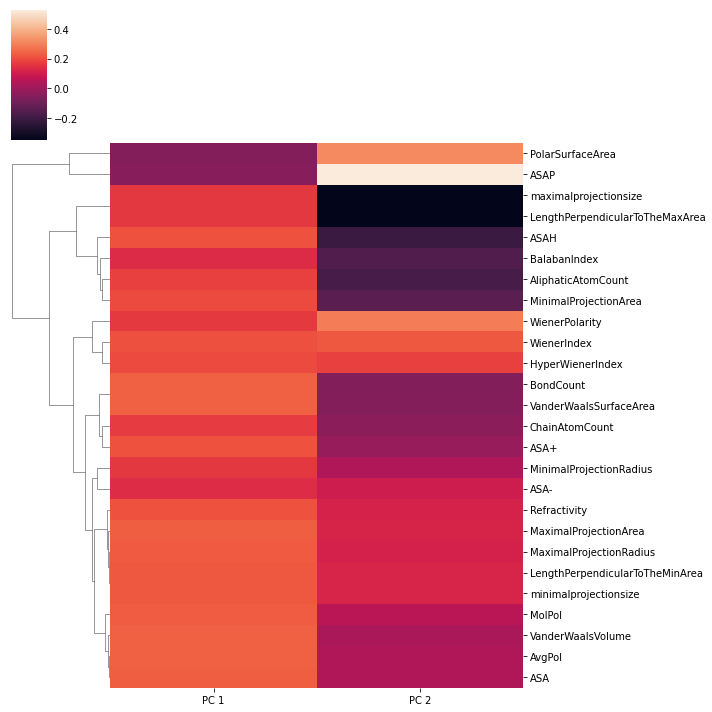

In [1770]:
sns.clustermap(loadings[["PC 1", "PC 2"]], col_cluster=False)

In [1780]:
def plot_scree_pca(df):
    with plt.style.context(['science', 'light']):
    #sns.set_palette(sns.color_palette(color_bright))
        plot_title = "figures/pca_varianza"
        
        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(4,4),
                                 constrained_layout = True)
        #fig.suptitle('Distribución de Reactivos')
        sns.barplot(x="Componente", y="Varianza Explicada", data=df, ax=axes, color='grey', alpha=0.50)
        
        news_x = [p.get_x() + p.get_width() / 2 for p in axes.patches]
        
        #sb.regplot(x='round', y='money', data=firm, ax=ax)
        sns.lineplot(x=news_x, y=df["Varianza Explicada Acumulada"], marker='o', legend="auto", color='grey', alpha=0.9, 
                     ax=axes)

        plt.xlabel('Número de componentes', fontsize=12)
        plt.ylabel('Varianza explicada', fontsize=12)
        
           
        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
    
        plt.ylim(0, 1)
        
        #fig.savefig(plot_title+'.pdf', dpi=300)
        

In [1781]:
pca, pca_df = apply_pca(df, df.columns, n_components)
explained = pd.DataFrame({"Componente":np.arange(1,n_components+1), "Varianza Explicada Acumulada":np.cumsum(pca.explained_variance_ratio_),
                         "Varianza Explicada": pca.explained_variance_ratio_})

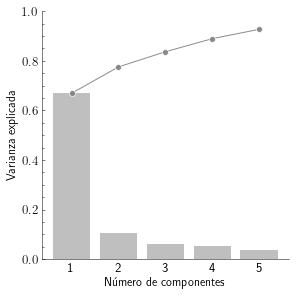

In [1782]:
plot_scree_pca(explained)

In [234]:
pca_df.shape

(43, 12)

In [238]:
pca.explained_variance_ratio_

array([0.35582188, 0.16592727, 0.10954005, 0.07860448, 0.06274814,
       0.05644324, 0.03781146, 0.0239753 , 0.02189544, 0.01862891,
       0.01807231, 0.01385441])

In [233]:
pca.components_.shape

(12, 57)

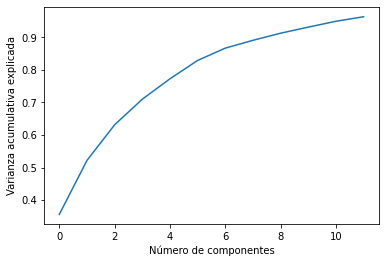

In [230]:
plot_scree_pca(pca)

In [75]:
df_corr = df.corr()

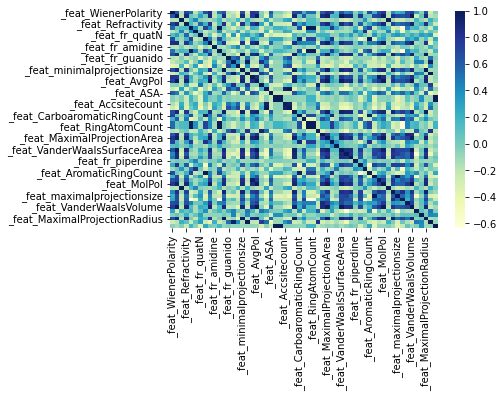

In [78]:
dataplot = sns.heatmap(df_corr, cmap="YlGnBu", annot=False)

In [66]:
corr_fq

,_feat_WienerPolarity,_feat_BondCount,_feat_fr_NH0,_feat_Refractivity,_feat_LargestRingSize,_feat_fr_ArN,_feat_HeteroaliphaticRingCount,_feat_fr_quatN,_feat_AromaticAtomCount,_feat_AtomCount_C,...,_feat_RotatableBondCount,_feat_maximalprojectionsize,_feat_ChainAtomCount,_feat_MinimalProjectionRadius,_feat_VanderWaalsVolume,_feat_ASA_P,_feat_fr_NH1,_feat_MaximalProjectionRadius,_feat_Hdonorcount,_feat_fr_pyridine
_feat_WienerPolarity,1.000000,0.634862,-0.172556,0.724316,0.540987,NaN,-0.192457,0.114474,0.668572,0.853608,...,0.405866,0.219548,0.274273,0.662178,0.757366,0.293373,-0.037944,0.652246,-0.262264,-0.048891
_feat_BondCount,0.634862,1.000000,-0.190451,0.887474,0.044159,NaN,-0.064999,0.297538,0.009115,0.875686,...,0.821335,0.699126,0.666027,0.709207,0.981319,-0.272638,0.060881,0.885574,-0.193232,-0.141117
_feat_fr_NH0,-0.172556,-0.190451,1.000000,-0.157481,0.136687,NaN,0.425385,-0.036451,-0.090468,-0.134123,...,-0.115844,-0.232879,-0.229474,-0.114722,-0.187105,0.179940,-0.062137,-0.162279,0.212174,-0.023810
_feat_Refractivity,0.724316,0.887474,-0.157481,1.000000,0.146463,NaN,-0.092526,0.556694,0.200777,0.806935,...,0.727617,0.520603,0.580299,0.658923,0.900522,0.056617,0.214255,0.830201,0.083539,-0.234189
_feat_LargestRingSize,0.540987,0.044159,0.136687,0.146463,1.000000,NaN,0.371568,-0.117945,0.722388,0.413633,...,-0.316139,-0.225550,-0.623901,0.439394,0.133902,0.184797,-0.084856,-0.008257,-0.249887,0.190119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_feat_ASA_P,0.293373,-0.272638,0.179940,0.056617,0.184797,NaN,-0.142673,0.092241,0.375268,-0.128297,...,-0.127573,-0.512341,-0.067299,-0.147339,-0.157627,1.000000,0.095796,-0.048106,0.486363,-0.032889
_feat_fr_NH1,-0.037944,0.060881,-0.062137,0.214255,-0.084856,NaN,0.063298,0.313921,-0.082277,-0.061691,...,0.117029,-0.072240,0.076261,0.086456,0.036476,0.095796,1.000000,0.014403,0.421445,0.383178
_feat_MaximalProjectionRadius,0.652246,0.885574,-0.162279,0.830201,-0.008257,NaN,-0.212000,0.236429,0.129630,0.818857,...,0.923456,0.530284,0.702656,0.503253,0.902315,-0.048106,0.014403,1.000000,-0.143643,-0.105631
_feat_Hdonorcount,-0.262264,-0.193232,0.212174,0.083539,-0.249887,NaN,0.069830,0.324824,-0.244301,-0.399779,...,-0.017760,-0.327184,0.052463,-0.150858,-0.231234,0.486363,0.421445,-0.143643,1.000000,-0.091942


In [56]:
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mp.show()

KeyError: "['_feat_msareaVDWp', '_feat_molsurfaceareaVDWp', '_feat_ProtPolarSurfaceArea', '_feat_msareaASAp', '_feat_molsurfaceareaASAp', '_feat_Protpsa'] not in index"